In [1]:
%load_ext autoreload
%autoreload 2

import sys

from archs.stable_diffusion.diffusion import latent_to_image
from archs.stable_diffusion.resnet import collect_dims
from archs.correspondence_utils import (
  process_image,
  rescale_points,
  draw_correspondences,
  compute_pck,
  find_nn_source_correspondences,
  find_best_buddies_correspondences,
  find_cyclical_correspondences,
)

import torch

import matplotlib.pyplot as plt

from PIL import Image
import numpy as np

from einops import (rearrange, reduce, repeat)
import cv2

from sklearn.decomposition import PCA

from extract_hyperfeatures import load_models

In [2]:
def visualize_depth_numpy(depth, minmax=None, cmap=cv2.COLORMAP_JET):
    """
    depth: (H, W)
    """

    x = np.nan_to_num(depth) # change nan to 0
    if minmax is None:
        mi = np.min(x[x>0]) # get minimum positive depth (ignore background)
        ma = np.max(x)
    else:
        mi,ma = minmax

    x = (x-mi)/(ma-mi+1e-8) # normalize to 0~1
    x = (255*x).astype(np.uint8)
    

    x_ = cv2.applyColorMap(x, cmap)
    x_ = cv2.cvtColor(x_, cv2.COLOR_BGR2RGB)
    return x_, [mi,ma]

In [3]:
# Memory requirement is 13731MiB
device = "cuda"
config_path = "/scratch/cvlab/home/afan/projects/diffusion_hyperfeatures/configs/test.yaml"
config, diffusion_extractor, aggregation_network = load_models(config_path, device)
load_size = (config["load_resolution"], config["load_resolution"])
output_size = (config["output_resolution"], config["output_resolution"])

{'weights_path': '/scratch/cvlab/home/afan/projects/diffusion_hyperfeatures/experiments/iscz5jec_sdv1-5_1-step_dim-8-256/checkpoint_step_4000.pt', 'load_resolution': 512, 'batch_size': 4, 'image_path': 'datasets/SPair-71k/JPEGImages', 'wandb_run': 'sdv1-5_1-step_dim-8-256', 'wandb_project': 'dhf', 'wandb_mode': 'online', 'results_folder': 'experiments', 'pck_threshold': 0.1, 'train_path': 'annotations/spair_71k_train.json', 'val_path': 'annotations/spair_71k_val-360.json', 'flip_timesteps': False, 'save_timestep': [0], 'num_timesteps': 1, 'weight_decay': 0, 'max_epochs': 1, 'max_steps_per_epoch': 5000, 'val_every_n_steps': 1000, 'plot_every_n_steps': -1, 'lr': 0.001, 'projection_dim': 8, 'num_norm_groups': 1, 'model_id': 'runwayml/stable-diffusion-v1-5', 'diffusion_mode': 'inversion', 'output_resolution': 256, 'prompt': '', 'negative_prompt': '', 'guidance_scale': -1}


model_index.json:   0%|          | 0.00/543 [00:00<?, ?B/s]

safety_checker/model.safetensors not found


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

text_encoder/config.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.70k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/307 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/246M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/608M [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/822 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
/scratch/cvlab/home/afan/miniconda3/envs/dhf/lib/python3.8/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


diffusion_mode: inversion
idxs: [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2), (3, 0), (3, 1), (3, 2)]
output_resolution: 256
prompt: 
negative_prompt: 


In [4]:
img1_pil = Image.open("/scratch/cvlab/datasets/dataset_afan/MIP360/bonsai/images_4/DSCF5565.JPG").convert("RGB")
img2_pil = Image.open("/scratch/cvlab/datasets/dataset_afan/MIP360/bonsai/images_4/DSCF5569.JPG").convert("RGB")
img3_pil = Image.open("/scratch/cvlab/datasets/dataset_afan/MIP360/bonsai/images_4/DSCF5573.JPG").convert("RGB")
img4_pil = Image.open("/scratch/cvlab/datasets/dataset_afan/MIP360/bonsai/images_4/DSCF5577.JPG").convert("RGB")


img1, img1_pil = process_image(img1_pil, res=load_size)
img2, img2_pil = process_image(img2_pil, res=load_size)
img3, img3_pil = process_image(img3_pil, res=load_size)
img4, img4_pil = process_image(img4_pil, res=load_size)
img1, img2, img3, img4 = img1.to(device), img2.to(device), img3.to(device), img4.to(device)
imgs = torch.cat([img1, img2, img3, img4])

print(imgs.shape)

with torch.inference_mode():
    with torch.autocast("cuda"):
        feats, _ = diffusion_extractor.forward(imgs)
        b, s, l, w, h = feats.shape
        diffusion_hyperfeats = aggregation_network(feats.float().view((b, -1, w, h)))
        print(diffusion_hyperfeats.shape)
        img1_hyperfeats = diffusion_hyperfeats[0][None, ...]
        img2_hyperfeats = diffusion_hyperfeats[1][None, ...]

torch.Size([4, 3, 512, 512])


/scratch/cvlab/home/afan/miniconda3/envs/dhf/lib/python3.8/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


torch.Size([4, 8, 256, 256])


/scratch/cvlab/home/afan/projects/diffusion_hyperfeatures/archs/aggregation_network.py:59: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  mixing_weights = torch.nn.functional.softmax(self.mixing_weights)


/scratch/cvlab/home/afan/projects/diffusion_hyperfeatures/archs/correspondence_utils.py:133: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  points2_y = points2 // num_pixels


(<Figure size 800x400 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

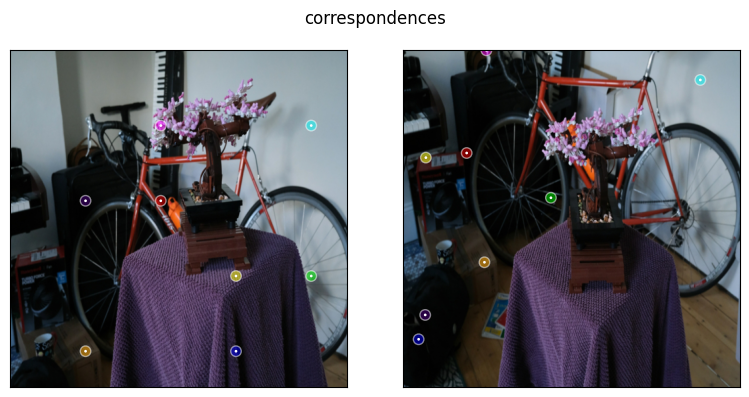

In [5]:
source_points = np.array([[100, 100], [150, 150], [200, 150], [150, 200], [50, 100], [100, 50], [200, 50], [50, 200]]) * 512 / 224
_, predicted_points = find_nn_source_correspondences(img1_hyperfeats, img2_hyperfeats, source_points, output_size, load_size)
draw_correspondences(source_points, predicted_points, img1_pil, img2_pil, title="correspondences")

In [6]:
img1_hyperfeats = diffusion_hyperfeats[0]
img2_hyperfeats = diffusion_hyperfeats[1]
img3_hyperfeats = diffusion_hyperfeats[2]
img4_hyperfeats = diffusion_hyperfeats[3]

color_1 = img1_hyperfeats[0:3, :, :].clip(0,1).permute(1,2,0).cpu().numpy()
color_2 = img2_hyperfeats[0:3, :, :].clip(0,1).permute(1,2,0).cpu().numpy()
color_3 = img3_hyperfeats[0:3, :, :].clip(0,1).permute(1,2,0).cpu().numpy()
color_4 = img4_hyperfeats[0:3, :, :].clip(0,1).permute(1,2,0).cpu().numpy()

(65536, 8)


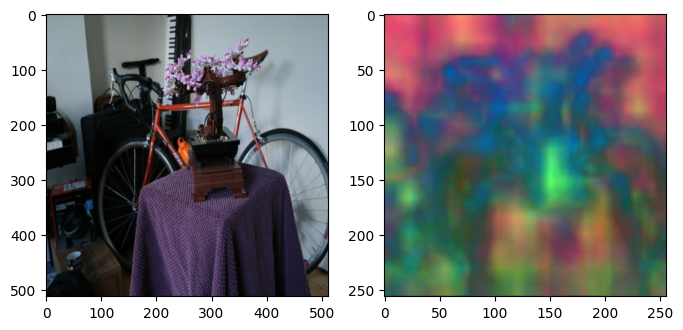

In [7]:
C, H, W = img1_hyperfeats.shape
test_feature = rearrange(img1_hyperfeats, "C H W -> (H W) C").cpu().numpy()
print(test_feature.shape)

pca = PCA(n_components=3)
pca.fit(test_feature)

pca_features = pca.transform(test_feature)
pca_features = (pca_features - pca_features.min()) / (pca_features.max() - pca_features.min())
pca_features = pca_features * 255

f, axarr = plt.subplots(1, 2, figsize=(8, 16)) 
axarr[0].imshow(img1_pil)
axarr[1].imshow(pca_features.reshape(H, W, 3).astype(np.uint8))


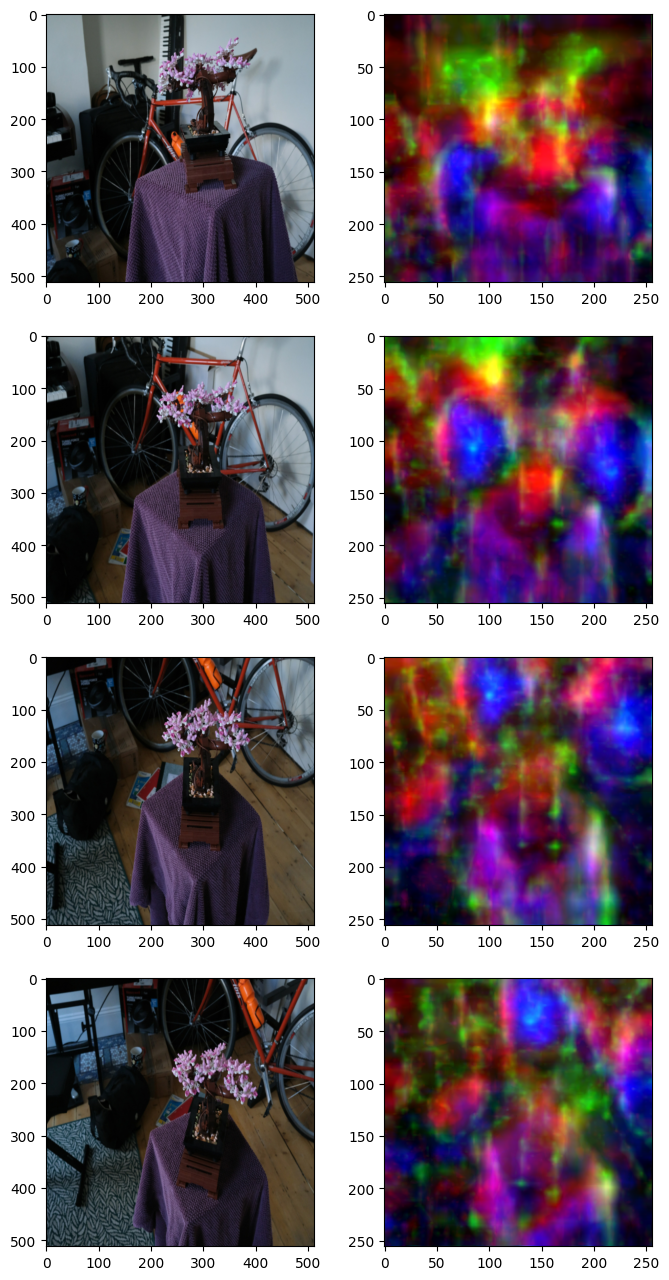

In [8]:
f, axarr = plt.subplots(4,2, figsize=(8, 16)) 

axarr[0,0].imshow(img1_pil)
axarr[0,1].imshow(color_1)
axarr[1,0].imshow(img2_pil)
axarr[1,1].imshow(color_2)
axarr[2,0].imshow(img3_pil)
axarr[2,1].imshow(color_3)
axarr[3,0].imshow(img4_pil)
axarr[3,1].imshow(color_4)
